# Sistema de Análise de Risco de Crédito

O objetivo deste projeto é desenvolver um modelo de Classificação Binária capaz de prever se um solicitante de empréstimo será um Bom Pagador (0) ou Inadimplente (1).





### Imports e Configuração

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Configuração de estilo dos gráficos
sns.set_style("whitegrid")
%matplotlib inline

### Coleta e Geração de Dados
Nesta etapa, geramos uma base de dados sintética com 1.500 clientes.
Criamos variáveis demográficas e financeiras aleatórias, mas dentro de faixas realistas (ex: Renda entre R$ 2.000 - R$20.000).

In [ ]:
np.random.seed(42)
n_clientes = 1500

data = {
    'Renda_Liquida': np.random.randint(2000, 20000, n_clientes),
    'Valor_Emprestimo': np.random.randint(1000, 50000, n_clientes),
    'Prazo_Meses': np.random.choice([12, 24, 36, 48, 60], n_clientes),
    'Score_Serasa': np.random.randint(300, 1000, n_clientes),
    'Negativado': np.random.choice([0, 1], n_clientes, p=[0.85, 0.15]),
    'Historico_Atraso': np.random.choice([0, 1], n_clientes, p=[0.75, 0.25])
}

df = pd.DataFrame(data)
print(f"Base de dados gerada com {df.shape[0]} linhas e {df.shape[1]} colunas.")
df.head()

Base de dados gerada com 1500 linhas e 6 colunas.


,Renda_Liquida,Valor_Emprestimo,Prazo_Meses,Score_Serasa,Negativado,Historico_Atraso
0,17795,11831,48,528,0,0
1,2860,6724,60,689,0,0
2,7390,12083,12,888,0,1
3,13964,46917,12,487,0,0
4,13284,20816,48,569,0,0


## Regras de negócio:

Aqui aplicamos a matemática financeira.

1.  **Cálculo da Parcela (PMT):** Utilizamos a fórmula da Tabela Price com juros de 4,96% a.m.
$$PMT = VP \times \frac{i(1+i)^n}{(1+i)^n - 1}$$

2.  **Cálculo do Comprometimento:** Verificamos quanto da renda é consumida pela parcela.
3.  **Definição do Target (Variável Alvo):** Criamos a lógica de quem paga e quem não paga baseada na soma dos fatores de risco.

In [ ]:
taxa_juros = 0.0496 # 4.96% ao mês

def calcular_pmt(valor, meses, taxa):
    return valor * (taxa * (1 + taxa)**meses) / ((1 + taxa)**meses - 1)

df['Valor_Parcela'] = df.apply(lambda x: calcular_pmt(x['Valor_Emprestimo'], x['Prazo_Meses'], taxa_juros), axis=1)

df['Comprometimento'] = df['Valor_Parcela'] / df['Renda_Liquida']

df['Passou_35'] = (df['Comprometimento'] > 0.35).astype(int)

def definir_risco(row):
    score_risco = 0

    if row['Score_Serasa'] < 500: score_risco += 3      # Peso alto
    if row['Negativado'] == 1: score_risco += 3         # Peso alto
    if row['Passou_35'] == 1: score_risco += 2          # Peso médio
    if row['Historico_Atraso'] == 1: score_risco += 1   # Peso baixo

    acaso = np.random.rand() * 2

    if (score_risco + acaso) > 4.5:
        return 1
    return 0

df['Target_Inadimplente'] = df.apply(definir_risco, axis=1)
print(df['Target_Inadimplente'].value_counts(normalize=True))

Target_Inadimplente
0    0.786
1    0.214
Name: proportion, dtype: float64


## Análise Exploratória de Dados (EDA)
Vamos visualizar como as variáveis se comportam em relação ao calote.

Score Serasa vs Inadimplência.
Renda vs Valor da Parcela.

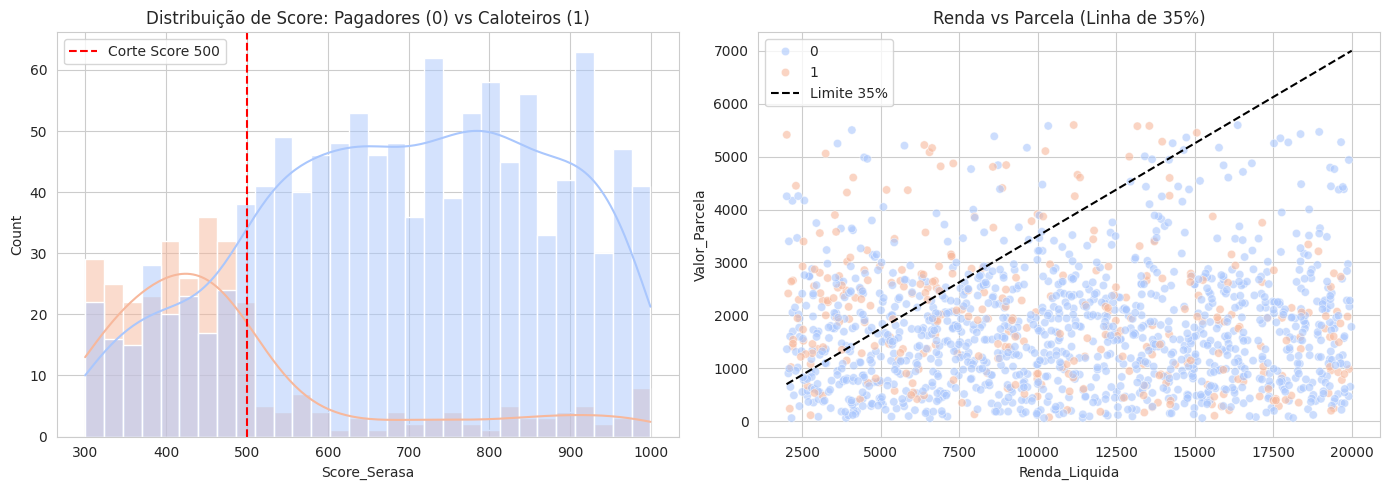

In [ ]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
sns.histplot(data=df, x='Score_Serasa', hue='Target_Inadimplente', bins=30, kde=True, palette='coolwarm')
plt.title('Distribuição de Score: Pagadores (0) vs Caloteiros (1)')
plt.axvline(500, color='red', linestyle='--', label='Corte Score 500')
plt.legend()

plt.subplot(1, 2, 2)
sns.scatterplot(data=df, x='Renda_Liquida', y='Valor_Parcela', hue='Target_Inadimplente', palette='coolwarm', alpha=0.6)

x_line = np.linspace(2000, 20000, 100)
y_line = x_line * 0.35
plt.plot(x_line, y_line, color='black', linestyle='--', label='Limite 35%')
plt.title('Renda vs Parcela (Linha de 35%)')
plt.legend()

plt.tight_layout()
plt.show()

## Treinamento de Modelos e Regularização

Vamos testar dois algoritmos clássicos:
1.  **Regressão Logística:** Modelo linear.
2.  **Árvore de Decisão:** Modelo não-linear.

### 🛡️ Tratamento de Overfitting (Regularização)
Para cumprir o requisito de regularização, aplicaremos **Poda (Pruning)** na Árvore de Decisão limitando a profundidade (`max_depth=3`). Isso evita que a árvore decore ruídos do treinamento e garante que ela aprenda apenas as regras principais.

In [ ]:
features = ['Renda_Liquida', 'Valor_Parcela', 'Comprometimento', 'Score_Serasa', 'Negativado', 'Historico_Atraso']
X = df[features]
y = df['Target_Inadimplente']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Modelo A: Árvore com Regularização (max_depth=3)
tree_model = DecisionTreeClassifier(max_depth=3, random_state=42)

# Modelo B: Regressão Logística
log_model = LogisticRegression()

tree_model.fit(X_train, y_train)
log_model.fit(X_train_scaled, y_train)

print("Modelos treinados.")

Modelos treinados.


## Avaliação e Comparação
Utilizaremos a **Matriz de Confusão** e o **Relatório de Classificação** (Precision, Recall, F1-Score).
Para concessão de crédito, observamos com atenção a **Precisão** da classe 0 (para ter certeza que estamos aprovando bons pagadores) e o **Recall** da classe 1 (capacidade de detectar "caloteiros").

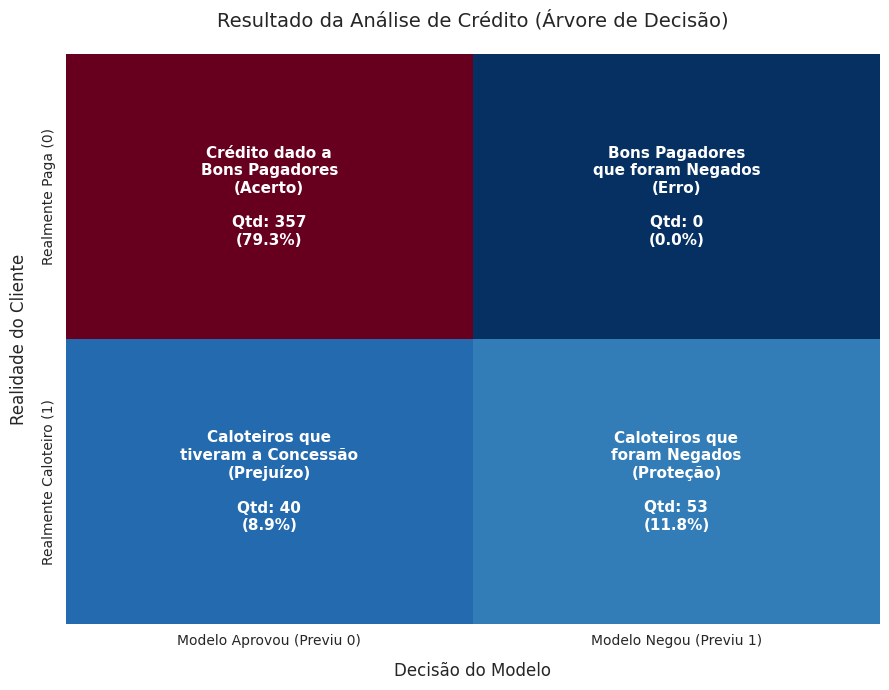

In [ ]:
cm = confusion_matrix(y_test, y_pred_tree)

frases = [
    "Crédito dado a\nBons Pagadores\n(Acerto)",   # TN: Real=0, Pred=0
    "Bons Pagadores\nque foram Negados\n(Erro)",  # FP: Real=0, Pred=1
    "Caloteiros que\ntiveram a Concessão\n(Prejuízo)", # FN: Real=1, Pred=0
    "Caloteiros que\nforam Negados\n(Proteção)"   # TP: Real=1, Pred=1
]

contagens = ["{0:0.0f}".format(value) for value in cm.flatten()]
porcentagens = ["{0:.1%}".format(value) for value in cm.flatten()/np.sum(cm)]

textos_finais = [f"{f}\n\nQtd: {c}\n({p})" for f, c, p in zip(frases, contagens, porcentagens)]
textos_finais = np.asarray(textos_finais).reshape(2,2)

plt.figure(figsize=(9, 7))

sns.heatmap(cm, annot=textos_finais, fmt='', cmap='RdBu_r', cbar=False,
            xticklabels=['Modelo Aprovou (Previu 0)', 'Modelo Negou (Previu 1)'],
            yticklabels=['Realmente Paga (0)', 'Realmente Caloteiro (1)'],
            annot_kws={"fontsize":11, "fontweight":"bold"}) # Aumenta a fonte do texto

plt.title('Resultado da Análise de Crédito (Árvore de Decisão)', fontsize=14, pad=20)
plt.xlabel('Decisão do Modelo', fontsize=12, labelpad=10)
plt.ylabel('Realidade do Cliente', fontsize=12, labelpad=10)
plt.tight_layout()
plt.show()

## Interpretação e Conclusão
O que o modelo aprendeu? Abaixo visualizamos as regras de decisão criadas pela árvore.
Isso valida se o modelo "entendeu" nossas regras de negócio (Score < 500, Comprometimento > 35%).

/tmp/ipython-input-1187210309.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importances, x='Importancia', y='Fator', palette='viridis')


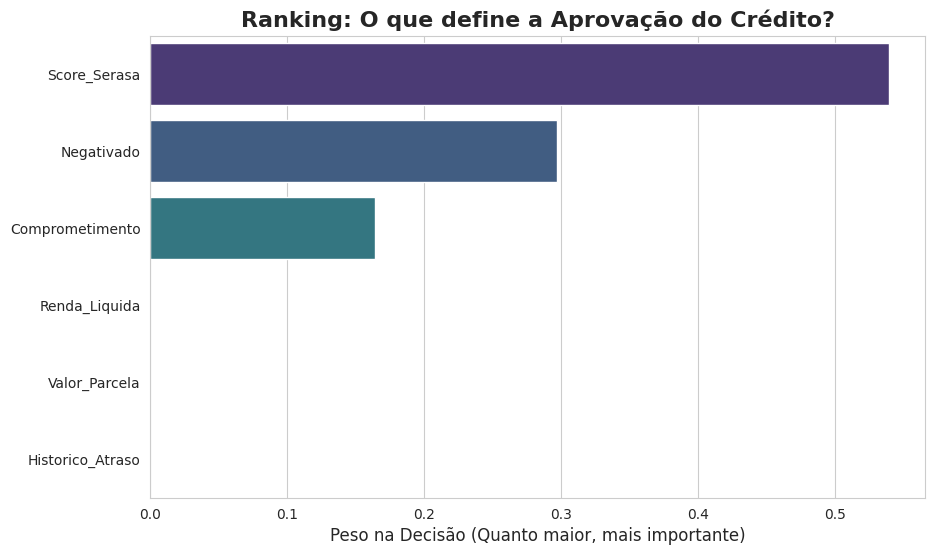

In [ ]:
importances = pd.Series(tree_model.feature_importances_, index=features).sort_values(ascending=False).reset_index()
importances.columns = ['Fator', 'Importancia']

plt.figure(figsize=(10, 6))
sns.barplot(data=importances, x='Importancia', y='Fator', palette='viridis')

plt.title('Ranking: O que define a Aprovação do Crédito?', fontsize=16, fontweight='bold')
plt.xlabel('Peso na Decisão (Quanto maior, mais importante)', fontsize=12)
plt.ylabel('')
plt.show()